In [38]:
import torch 
import matplotlib.pyplot as plt
import copy
from fmfts.experiments.rti3d_sliced.training_parameters import params
from fmfts.dataloader.rti3d_sliced import DatasetSlicedRTI3D
from fmfts.experiments.rti3d_sliced.models import VelocityModelSlicedRTI3D, \
                                                  SingleStepModelSlicedRTI3D, \
                                                  FlowModelSlicedRTI3D
from fmfts.utils.models.cfm_rectifier import Rectifier
from fmfts.utils.models.add import AdversarialDiffusionDistillation

torch.set_grad_enabled(False)
torch.set_default_device("cuda")

velocity = VelocityModelSlicedRTI3D(**params["velocity"]["model_kwargs"])
velocity.load_state_dict(torch.load("trained_models/state_velocity.pt", weights_only=True)["model"])
single_step = SingleStepModelSlicedRTI3D(velocity_model = copy.deepcopy(velocity), **params["single_step"]["model_kwargs"])
single_step.load_state_dict(torch.load("trained_models/state_single_step.pt", weights_only=True)["model"])
flow = FlowModelSlicedRTI3D(velocity_model = copy.deepcopy(velocity), **params["flow"]["model_kwargs"])
flow.load_state_dict(torch.load("trained_models/state_flow.pt", weights_only=True)["model"])
add00 = AdversarialDiffusionDistillation(velocity_model = copy.deepcopy(velocity))
add00.load_state_dict(torch.load("trained_models/state_add_wdistill00.pt", weights_only=True)["model"])
add05 = AdversarialDiffusionDistillation(velocity_model = copy.deepcopy(velocity))
add05.load_state_dict(torch.load("trained_models/state_add_wdistill05.pt", weights_only=True)["model"])
add09 = AdversarialDiffusionDistillation(velocity_model = copy.deepcopy(velocity))
add09.load_state_dict(torch.load("trained_models/state_add_wdistill09.pt", weights_only=True)["model"])

rectifier = Rectifier(velocity_model = copy.deepcopy(velocity))
rectifier.load_state_dict(torch.load("trained_models/state_rectifier_2.pt", weights_only=True)["model"])
rectified_velocity = rectifier.rectified_velocity_model

dataset_test = DatasetSlicedRTI3D(mode="test", **params["dataset"]["kwargs"])

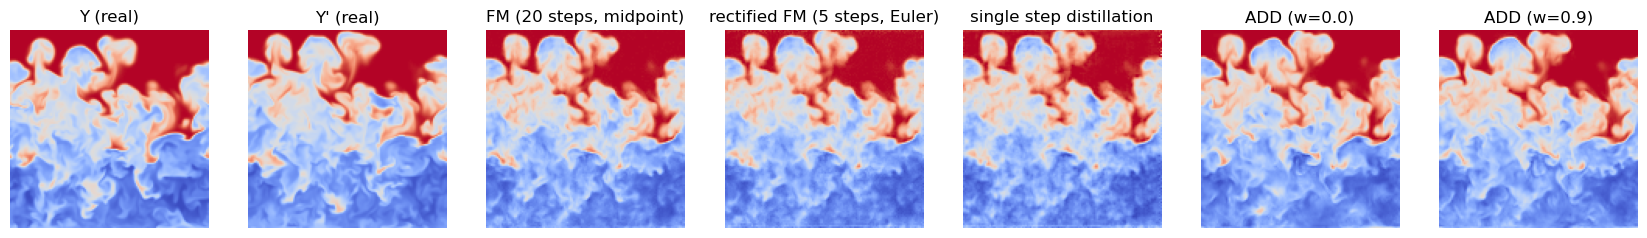

In [39]:
# demonstrates how one can predict a single sample
y, x = dataset_test.get(0, 90, 64, sequence_len=2)
x0 = velocity.p0.sample(y[None].shape).to(y.device)
# x_pred  = flow.sample(y[None], x0=x0, steps=100 )
# x_pred1 = flow.sample(y[None], x0=x0, steps=10  )
# x_pred2 = flow.sample(y[None], x0=x0, steps=1   )
x_pred_single_step = single_step.sample(y[None], x0=x0)
# x_pred_velocity_single_step = velocity.sample(y[None], x0=x0, steps=1, method="euler")
x_pred_velocity = velocity.sample(y[None], x0=x0, steps=20, method="midpoint")
x_pred_rectified_velocity = rectified_velocity.sample(y[None], x0=x0, steps=5, method="euler")
x_pred_add00 = add00(y=y[None], x=x0)
x_pred_add09 = add09(y=y[None], x=x0)

# plotting
fig, ax = plt.subplots(1, 7, figsize=(7*3, 3))
dataset_test.plot(y, ax[0])
dataset_test.plot(x, ax[1])
dataset_test.plot(x_pred_velocity, ax[2])
dataset_test.plot(x_pred_rectified_velocity, ax[3])
dataset_test.plot(x_pred_single_step, ax[4])
dataset_test.plot(x_pred_add00, ax[5])
dataset_test.plot(x_pred_add09, ax[6])
# dataset_test.plot(x_pred_velocity_single_step, ax[6])
ax[0].set_title("Y (real)")
ax[1].set_title("Y' (real)")
ax[2].set_title("FM (20 steps, midpoint)")
ax[3].set_title("rectified FM (5 steps, Euler)")
ax[4].set_title("single step distillation")
ax[5].set_title("ADD (w=0.0)")
ax[6].set_title("ADD (w=0.9)")
# ax[6].set_title("x(t+dt) ~ velocity (single step)")
for i in range(len(ax)): ax[i].axis("off")
plt.show()

torch.Size([15, 5, 128, 128])


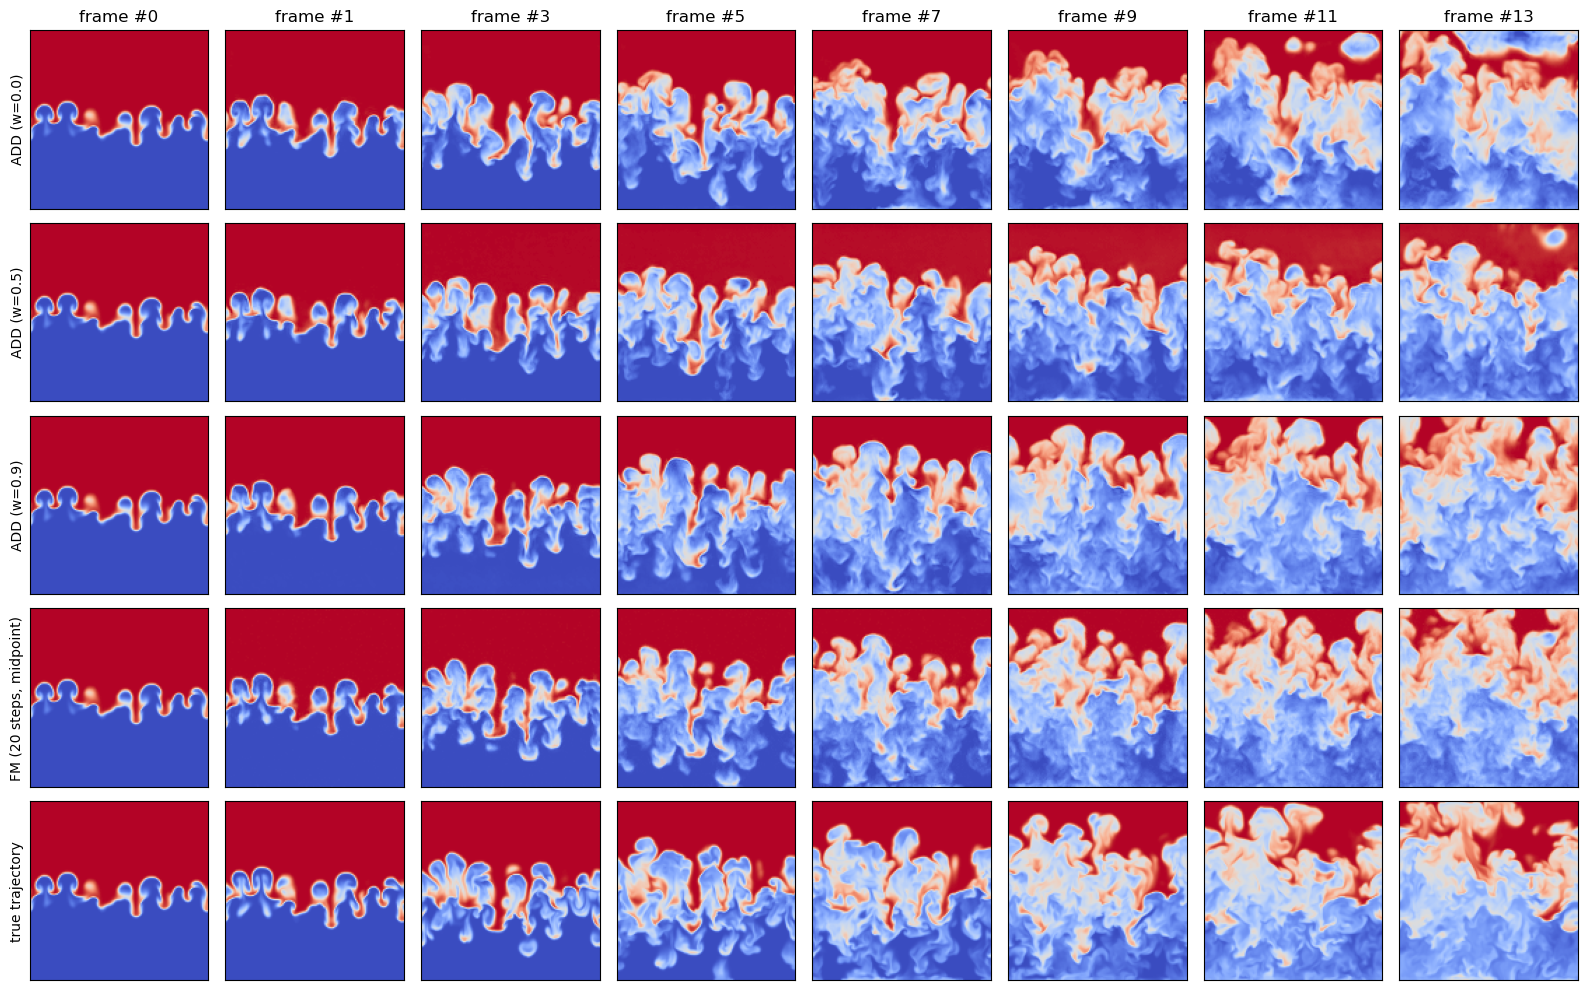

In [45]:
# demonstrates how one can generate multiple trajectories
n_trajectories = 4
n_predictions = 15
y = dataset_test.get(0, 40, 64, sequence_len=n_predictions)
print(y.shape)

xs_ml = torch.empty(n_predictions, n_trajectories, *y.shape[1:])
xs_ml[0,:] = y[0].clone()
for k in range(n_predictions-1):
    # xs[k+1,0,None] = flow.sample(xs[k,0,None], steps=1) 
    # xs[k+1,0,None] = velocity.sample(xs[k,0,None], steps=50, method="euler") 
    # xs[k+1,1,None] = velocity.sample(xs[k,1,None], steps=50, method="euler") 
    x0 = flow.p0.sample(xs_ml[k,0,None].shape).to(xs_ml.device)
    xs_ml[k+1,0,None] = add00.G(y=xs_ml[k,0,None], x=x0)
    # xs_ml[k+1,0,None] = velocity.sample(xs_ml[k,0,None], x0=x0, steps=20, method="midpoint", c_ml = 0.00)
    x0 = flow.p0.sample(xs_ml[k,0,None].shape).to(xs_ml.device)
    xs_ml[k+1,1,None] = add05.G(y=xs_ml[k,1,None], x=x0)
    x0 = flow.p0.sample(xs_ml[k,0,None].shape).to(xs_ml.device)
    xs_ml[k+1,2,None] = add09.G(y=xs_ml[k,2,None], x=x0)
    
    xs_ml[k+1,3,None] = velocity.sample(xs_ml[k,3,None], x0=x0, steps=20, method="midpoint", c_ml = 0.0) 
    # xs_ml[k+1,2,None] = velocity.sample(xs_ml[k,2,None], x0=x0, steps=20, method="midpoint", c_ml = 0.20)
    # xs[k+1,1,None] = flow.sample(xs[k,1,None], x0=x0, steps=1)
    # xs[k+1,1,None] = single_step.sample(xs[k,1,None], x0=x0)
    # xs[k+1,1,None] = velocity.sample(xs[k,1,None], x0=x0, steps=50, method="midpoint")
    # xs[k+1] = single_step.sample(xs[k])

# plotting
n_plots   = 8

fig, ax = plt.subplots(n_trajectories + 1, n_plots, figsize=(n_plots*2, (n_trajectories+1)*2))
for k in range(n_trajectories):
    for i in range(n_plots):
        l = i * n_predictions // n_plots
        dataset_test.plot(xs_ml[l, k], ax[k, i])
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])

ax[0,0].set_ylabel(f"ADD (w=0.0)")
ax[1,0].set_ylabel(f"ADD (w=0.5)")
ax[2,0].set_ylabel(f"ADD (w=0.9)")
ax[3,0].set_ylabel(f"FM (20 steps, midpoint)")

for i in range(n_plots):
    l = i * n_predictions // n_plots
    if l < len(y): 
        dataset_test.plot(y[l], ax[-1, i])
        ax[-1, i].set_xticks([])
        ax[-1, i].set_yticks([])
    else:                          
        ax[-1, i].remove()
    ax[0, i].set_title(f"frame #{l}")
ax[-1, 0].set_ylabel("true trajectory")

plt.tight_layout()
plt.show()

Training times:
- single step: 3d on 50% A100 power
- params: 128-196-256
- lr: 1e-4 -- 1e-5
- 10 intermediate steps

- flow: 3d on 50% A100 power
- params: 128-196-256
- lr: 1e-4 -- 1e-5
- 5 intermediate steps